<a href="https://www.kaggle.com/code/pkappaka3/paddy-doctor-multimodel-v3-2?scriptVersionId=205708444" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Check if the dataset is imbalanced ??

In [1]:
# !nvidia-smi

In [2]:
competition_name = "paddy-disease-classification"
interacting = True
tracking = False
submitting= False

In [3]:
!pip install mlflow --quiet
!pip install pyngrok --quiet


Read the MLFlow authentication tokens from colab secrets

In [4]:
if tracking:
    import mlflow, os
    from pyngrok import ngrok
    if os.getenv("COLAB_RELEASE_TAG"):
        from google.colab import userdata
        os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')
        os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
    else:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        os.environ['MLFLOW_TRACKING_USERNAME'] = user_secrets.get_secret("MLFLOW_TRACKING_USERNAME")
        os.environ['MLFLOW_TRACKING_PASSWORD'] = user_secrets.get_secret("MLFLOW_TRACKING_USERNAME")
    os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'PADDYDOCTOR'

Start the MLFlow service in background on port 5000 for run logging in MLFlow

In [5]:
if tracking:
    # run tracking UI in the background
    get_ipython().system_raw("mlflow ui --port 5000 &")# run tracking UI in the background

Using ngrok connect MLFLow local service URL to internet

In [6]:
if tracking:
    !ngrok config check

In [7]:
if tracking:
    # Terminate open tunnels if exist
    ngrok.kill()

    # Setting the authtoken (optional)
    # Get your authtoken from https://dashboard.ngrok.com/auth
    if os.getenv("COLAB_RELEASE_TAG"):
        NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    else:
        NGROK_AUTH_TOKEN = user_secrets.get_secret("NGROK_AUTH_TOKEN")
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

    # Check if a tunnel is already running before starting a new one
    active_tunnels = ngrok.get_tunnels()
    active_tunnels
    if not active_tunnels:
        # Open an HTTPs tunnel on port 5000 for http://localhost:5000
        public_url = ngrok.connect(5000, name='MLFLow URL')
        print("MLflow Tracking UI:", public_url)
    else:
        print("An ngrok tunnel is already running:", active_tunnels[0].public_url)
        public_url = active_tunnels[0].public_url # Use the existing tunnel's URL

In [8]:
# Cleanup function
def cleanup():
    # Close MLflow run if any is active
    try:
        mlflow.end_run()
    except:
        pass

    # Disconnect ngrok
    try:
        ngrok.disconnect(listener.url())
        ngrok.kill()  # Kill the ngrok process
    except:
        pass

    # Kill MLflow server (optional, if you want to completely shut down the server)
    !pkill -f "mlflow server"

Invoke cleanup at the end to stop MLFlow logging

In [9]:
if tracking:
    # Create a new experiment
    try:
        experiment = mlflow.create_experiment('convnext_tiny')
    except mlflow.exceptions.MlflowException as e:
        # If experiment already exists, get its ID
        experiment = mlflow.get_experiment_by_name('convnext_tiny').experiment_id

    # Set the experiment
    mlflow.set_experiment('convnext_tiny')

A trial parameter logging on MLFlow

In [10]:
# import os
# if os.getenv("COLAB_RELEASE_TAG"):
#    print("Running in Colab")
# else:
#    print("NOT in Colab")

If notebook on colab, grant access to my google drive and access from notebook

In [11]:
# Mount your Google Drive.
import os
if os.getenv("COLAB_RELEASE_TAG"):
  file_path = "/content/drive"
  if not os.path.exists(file_path):
    from google.colab import drive
    drive.mount("/content/drive")

In [12]:
! pip install kaggle --quiet

If notebook on colab copy my kaggle token from my google drive to .kaggle directory to authenticate with kaggle for data dowload and notebook upload to kaggle.

In [13]:
if os.getenv("COLAB_RELEASE_TAG"):
  file_path = "~/.kaggle/kaggle.json"
  if not os.path.exists(file_path):
    kaggle_creds_path = "/content/drive/MyDrive/kaggle.json"
    ! mkdir ~/.kaggle
    ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

In [14]:
!pip install fastkaggle --quiet
!pip install fastai --upgrade --quiet

In [15]:
from fastai.vision.all import *
from fastkaggle import *  # for easy Kaggle dataset access

If notebook on colab download the dataset from kaggle if the dataset is not already present in my google drive.

In [16]:
# Set up Kaggle credentials (you'll need to provide your kaggle.json file)
if os.getenv("COLAB_RELEASE_TAG"):
  save_data_drive_path='/content/drive/MyDrive/paddy-disease-classification'
  if not os.path.exists(save_data_drive_path):
    file_path = "/content/paddy-disease-classification.zip"
    if not os.path.exists(file_path):
      setup_comp('paddy-disease-classification', 'train.csv')
  else:
    print("Data already downloaded and saved in drive")

If notebook on colab download the dataset from kaggle if the dataset is not already present in my google drive and copy to my google drive.

In [17]:
if os.getenv("COLAB_RELEASE_TAG"):
  import zipfile
  if not os.path.exists(save_data_drive_path):
    os.mkdir(save_data_drive_path)
  dir = os.listdir(save_data_drive_path)
  if len(dir) == 0:
    with zipfile.ZipFile('paddy-disease-classification.zip', 'r') as zip_ref:
      zip_ref.extractall(save_data_drive_path)

check if the notebook is running in GPU or CPU and use this variable to change the training methods according to the processor.

In [18]:
# Check available device and set defaults
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
import fastai.torch_core
if device == 'cpu':
    fastai.torch_core.default_device(use=False)

Using device: cuda


In [19]:
# import os
if device == 'cuda':
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments'
    print(os.environ['CUDA_LAUNCH_BLOCKING'], os.environ['PYTORCH_CUDA_ALLOC_CONF'])
    import torch
    !unset PYTORCH_CUDA_ALLOC_CONF

    # Explicitly delete the environment variable if present
    if "PYTORCH_CUDA_ALLOC_CONF" in os.environ:
        del os.environ["PYTORCH_CUDA_ALLOC_CONF"]
        print("PYTORCH_CUDA_ALLOC_CONF deleted from environment.")
    

1 expandable_segments
PYTORCH_CUDA_ALLOC_CONF deleted from environment.


If google colab notebook set the input paths accordingly, otherwise set the input paths according to kaggle paths.

In [20]:
# Set paths
if os.getenv("COLAB_RELEASE_TAG"):
  path = Path(save_data_drive_path)
  train_path = path/'train_images'
  test_path = path/'test_images'
elif iskaggle:
    path = Path('../input/paddy-disease-classification')
    train_path = path/'train_images'
    test_path = path/'test_images'
print(f"Train path: {train_path}")  # Print the train path
print(f"Test path: {test_path}")   # Print the test path

Train path: ../input/paddy-disease-classification/train_images
Test path: ../input/paddy-disease-classification/test_images


Instead of the get_image_files which will load all the images into the DataBlock for training created a custom function get_subset_items. Will use this loader function during the initial trial runs to quick perform training with a smaller dataset to verify the code and then switch back to get_image_files for the final run. Ensure that the subset is not too small, there is a risk some labels are not included and training will fail. Additional steps can be added within the get_subset_items to get a more equitable sampling of images.

In [21]:
if os.getenv("COLAB_RELEASE_TAG"):
  model_path='/content/drive/MyDrive/paddy-disease-classification/models'
  if not os.path.exists(model_path):
    os.mkdir(model_path)
import shutil

In [22]:
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head()

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45


In [23]:
def get_variety(p): return df.loc[p.name, 'variety']

In [24]:
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y = [parent_label,get_variety],
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(train_path, batch_size = 16)

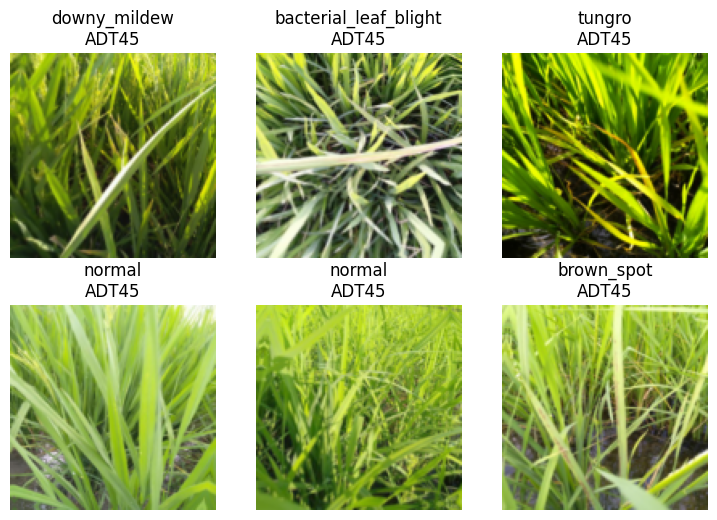

In [25]:
if interacting:
    dls.show_batch(max_n=6)

In [26]:
def disease_err(inp,disease,variety): return error_rate(inp,disease)
def disease_loss(inp,disease,variety): return F.cross_entropy(inp,disease)

In [27]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from fastai.vision.all import *

# def compare_distributions(train_labels, val_labels):
#     """
#     Displays normalized histograms of training and validation labels side by side
#     for easy distribution comparison.
#     """
#     # Create normalized distributions
#     train_counts = pd.Series(train_labels).value_counts(normalize=True)
#     val_counts = pd.Series(val_labels).value_counts(normalize=True)
    
#     # Ensure both distributions have the same labels (categories)
#     all_labels = sorted(list(set(train_counts.index) | set(val_counts.index)))
#     train_counts = train_counts.reindex(all_labels, fill_value=0)
#     val_counts = val_counts.reindex(all_labels, fill_value=0)
    
#     # Set up the plot
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
#     fig.suptitle('Training vs Validation Data Distribution Comparison', fontsize=14)
    
#     # Plot training distribution
#     bars1 = ax1.bar(all_labels, train_counts.values)
#     ax1.set_title('Training Data Distribution')
#     ax1.set_xlabel('Labels')
#     ax1.set_ylabel('Frequency (Normalized)')
#     # Correct way to set tick rotation and alignment
#     ax1.tick_params(axis='x', rotation=45)
#     ax1.set_xticklabels(all_labels, ha='right')
    
#     # Plot validation distribution
#     bars2 = ax2.bar(all_labels, val_counts.values)
#     ax2.set_title('Validation Data Distribution')
#     ax2.set_xlabel('Labels')
#     ax2.set_ylabel('Frequency (Normalized)')
#     # Correct way to set tick rotation and alignment
#     ax2.tick_params(axis='x', rotation=45)
#     ax2.set_xticklabels(all_labels, ha='right')
    
#     # Ensure both plots have the same y-axis scale
#     max_freq = max(train_counts.max(), val_counts.max())
#     ax1.set_ylim(0, max_freq * 1.15)  # Add 15% padding
#     ax2.set_ylim(0, max_freq * 1.15)
    
#     # Add percentage labels on bars
#     def add_percentages(ax, bars):
#         for bar in bars:
#             percentage = '{:.1f}%'.format(100 * bar.get_height())
#             ax.annotate(percentage,
#                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
#                        xytext=(0, 3),
#                        textcoords="offset points",
#                        ha='center',
#                        va='bottom')
    
#     add_percentages(ax1, bars1)
#     add_percentages(ax2, bars2)
    
#     # Calculate distribution difference statistics
#     print("\nDistribution Difference Analysis:")
#     print("-" * 50)
#     print(f"{'Label':<15} {'Train %':<10} {'Val %':<10} {'Diff %':<10}")
#     print("-" * 50)
#     for label in all_labels:
#         train_pct = train_counts[label] * 100
#         val_pct = val_counts[label] * 100
#         diff = abs(train_pct - val_pct)
#         print(f"{label:<15} {train_pct:>8.1f}% {val_pct:>8.1f}% {diff:>8.1f}%")
    
#     # Calculate KL divergence
#     epsilon = 1e-10  # Small constant to avoid log(0)
#     kl_div = np.sum(train_counts * np.log((train_counts + epsilon) / (val_counts + epsilon)))
#     print(f"\nKL Divergence: {kl_div:.4f}")
    
#     plt.tight_layout()
#     plt.show()

# if interacting:

#     # Setup your FastAI DataLoaders
#     dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2)

#     # Get training and validation labels
#     train_labels = [os.path.basename(os.path.dirname(path)) for path in dls.train_ds.items] 
#     val_labels = [os.path.basename(os.path.dirname(path)) for path in dls.valid_ds.items]

#     # Compare distributions
#     compare_distributions(train_labels, val_labels)

In [28]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from fastai.vision.all import *

# def compare_distributions(train_labels, val_labels):
#     """
#     Displays normalized histograms of training and validation labels side by side
#     for easy distribution comparison.
#     """
#     # Create normalized distributions
#     train_counts = pd.Series(train_labels).value_counts(normalize=True)
#     val_counts = pd.Series(val_labels).value_counts(normalize=True)
    
#     # Ensure both distributions have the same labels (categories)
#     all_labels = sorted(list(set(train_counts.index) | set(val_counts.index)))
#     train_counts = train_counts.reindex(all_labels, fill_value=0)
#     val_counts = val_counts.reindex(all_labels, fill_value=0)
    
#     # Set up the plot
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
#     fig.suptitle('Training vs Validation Data Distribution Comparison', fontsize=14)
    
#     # Plot training distribution
#     bars1 = ax1.bar(all_labels, train_counts.values)
#     ax1.set_title('Training Data Distribution')
#     ax1.set_xlabel('Labels')
#     ax1.set_ylabel('Frequency (Normalized)')
#     # Correct way to set tick rotation and alignment
#     ax1.tick_params(axis='x', rotation=45)
#     ax1.set_xticklabels(all_labels, ha='right')
    
#     # Plot validation distribution
#     bars2 = ax2.bar(all_labels, val_counts.values)
#     ax2.set_title('Validation Data Distribution')
#     ax2.set_xlabel('Labels')
#     ax2.set_ylabel('Frequency (Normalized)')
#     # Correct way to set tick rotation and alignment
#     ax2.tick_params(axis='x', rotation=45)
#     ax2.set_xticklabels(all_labels, ha='right')
    
#     # Ensure both plots have the same y-axis scale
#     max_freq = max(train_counts.max(), val_counts.max())
#     ax1.set_ylim(0, max_freq * 1.15)  # Add 15% padding
#     ax2.set_ylim(0, max_freq * 1.15)
    
#     # Add percentage labels on bars
#     def add_percentages(ax, bars):
#         for bar in bars:
#             percentage = '{:.1f}%'.format(100 * bar.get_height())
#             ax.annotate(percentage,
#                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
#                        xytext=(0, 3),
#                        textcoords="offset points",
#                        ha='center',
#                        va='bottom')
    
#     add_percentages(ax1, bars1)
#     add_percentages(ax2, bars2)
    
#     # Calculate distribution difference statistics
#     print("\nDistribution Difference Analysis:")
#     print("-" * 50)
#     print(f"{'Label':<15} {'Train %':<10} {'Val %':<10} {'Diff %':<10}")
#     print("-" * 50)
#     for label in all_labels:
#         train_pct = train_counts[label] * 100
#         val_pct = val_counts[label] * 100
#         diff = abs(train_pct - val_pct)
#         print(f"{label:<15} {train_pct:>8.1f}% {val_pct:>8.1f}% {diff:>8.1f}%")
    
#     # Calculate KL divergence
#     epsilon = 1e-10  # Small constant to avoid log(0)
#     kl_div = np.sum(train_counts * np.log((train_counts + epsilon) / (val_counts + epsilon)))
#     print(f"\nKL Divergence: {kl_div:.4f}")
    
#     plt.tight_layout()
#     plt.show()

# if interacting:
#     # Setup your FastAI DataLoaders
#     dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2)
#     dls.train_ds.items[0].name
#     # dls.train_ds[0]
#     # get_variety(dls.train_ds.items[0])

#     train_labels = [get_variety(path) for path in dls.train_ds.items]
#     val_labels = [get_variety(path) for path in dls.valid_ds.items]
#     # val_labels[0]

#     # Compare distributions
#     compare_distributions(train_labels, val_labels)

In [29]:
# dls.train_ds.items[0]

In [30]:
# val_labels = [os.path.basename(os.path.dirname(path)) for path in dls.train_ds.items] 
# val_labels[0]

In [31]:
arch = 'convnext_small_in22k'
learn = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr = 0.01

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


In [32]:
learn.fine_tune(3, lr)

/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/opt/conda/lib/python3.10/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,disease_err,time
0,1.398396,0.928075,0.287842,01:49


epoch,train_loss,valid_loss,disease_err,time
0,0.711886,0.407240,0.133109,02:42
1,0.613618,0.360844,0.112926,02:43
2,0.334924,0.204175,0.064392,02:39
3,0.161986,0.143829,0.040365,02:39
4,0.139612,0.127344,0.036040,02:34


In [35]:
learn.export('/kaggle/working/export.pkl')

In [36]:
img_path = path/'train_images/bacterial_leaf_blight/100330.jpg'
tst_dl = learn.dls.test_dl(str(img_path))

In [39]:
preds,_ = learn.tta(dl=tst_dl)

In [ ]:
preds

In [41]:
vocab = np.array(dls.vocab)
vocab[0]
# disease = vocab[0]
# variety = vocab[1]
# age = vocab[2]
# idxs_disease = preds[:,:len(disease)].argmax(dim=1)
# results_disease = pd.Series(disease[idxs_disease], name="idxs_disease")
# idxs_variety = preds[:,len(disease):(len(disease)+len(variety))].argmax(dim=1)
# results_variety = pd.Series(variety[idxs_variety], name="idxs_variety")
# idxs_age = preds[:,(len(disease)+len(variety)):(len(disease)+len(variety)+len(age))].argmax(dim=1)
# results_age = pd.Series(age[idxs_age], name="idxs_age")

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype='<U24')

In [34]:
learn.show_results()

AssertionError: Match length mismatch

In [ ]:
def get_subset_items(path):
    """Selects 25 images per label from the dataset."""
    all_files = get_image_files(path)
    subset_files = []
    sample_size=250

    # Get unique labels from filenames (assuming labels are in the filenames)
    labels = set([f.parent.name for f in all_files])

    for label in labels:
        # Get all files with the current label
        label_files = [f for f in all_files if f.parent.name == label]

        # Shuffle and select 25 files for the current label
        subset_files.extend(L(label_files).shuffle()[:sample_size])

    print(f"Selected {len(subset_files)} images ( {sample_size} per label) out of {len(all_files)} total images.")
    return subset_files

item_tfms are applied inidividually on each image. batch_tfms are applied to the whole batch of images. These two data augmentation steps are passed to the DataBlock to apply on the data defined in the DataBlock.

My Google drive path to save the model

In [ ]:
# tta_res = []

Defined a training method,

*   Set the batch size with bs parameter
*   Use the DataBlock defined above for data loading
*   Use gradient accumulator after every 2 epochs ??



In [ ]:
def train(arch, desc, item, batch, epochs=10,accum=False):
    torch.cuda.empty_cache()
    kwargs = { 'bs': 16 } if accum else {}
    paddy_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,#get_subset_items,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=item,
    batch_tfms=batch
    )
    dls = paddy_block.dataloaders(train_path, **kwargs)
    cbs = GradientAccumulation(2) if accum else []
    learn = vision_learner(dls, arch, metrics=[error_rate,accuracy, top_k_accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')]).to_fp16()
    learn.fine_tune(epochs, 0.01)
    lrn_rcd_vals = learn.recorder.values[-1]
    # tta_res.append(learn.tta(dl=dls.test_dl(test_path.ls())))
    learn.export(f'{arch}_{desc}.pkl')
    return learn, lrn_rcd_vals

Initiate training for the resnet26d archicture pretrained model

In [ ]:
# arch='resnet26d'
# learn = train('squish',arch,item=Resize(480,method='squish'),batch=aug_transforms(size=224,min_scale=0.75))
# learn.show_results()

Initiate the training for the convnext_tiny pretrained model architecture

In [ ]:
import torch
!unset PYTORCH_CUDA_ALLOC_CONF

# Explicitly delete the environment variable if present
if "PYTORCH_CUDA_ALLOC_CONF" in os.environ:
    del os.environ["PYTORCH_CUDA_ALLOC_CONF"]
    print("PYTORCH_CUDA_ALLOC_CONF deleted from environment.")


arch='convnext_small_in22k' #convnext_tiny'
v_image_size = (80,106)
#Enhanced data augmentation pipeline
# items = [
#     RandomResizedCrop(460, min_scale=0.75),  # Randomly crop and resize
#     FlipItem(p=0.5),  # Horizontal flip with 50% probability
# ]

# batchs = [
#     *aug_transforms(
#         size=v_image_size,
#         max_rotate=10.0,  # Rotation up to 10 degrees
#         max_zoom=1.1,     # Zoom in up to 10%
#         max_lighting=0.2, # Adjust brightness
#         max_warp=0.2,    # Perspective warping
#         p_affine=0.75,   # Probability of applying affine transforms
#         p_lighting=0.75,  # Probability of applying lighting transforms
#     ),
#     Normalize.from_stats(*imagenet_stats),
#     RandomErasing(p=0.5, max_count=2)  # Random erasing for occlusion robustness
# ]

# learn , lrn_rcd_vals = train(arch,desc='size80160',item=items,batch=batchs)

In [ ]:
desc='size80160'
learn , lrn_rcd_vals = train(arch, desc=desc,item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),batch=aug_transforms(size=v_image_size, min_scale=0.75))

In [ ]:
if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f'{arch}_{desc}.pkl', f'{model_path}/{arch}_{desc}.pkl')

In [ ]:
# lrn_rcd_vals

In [ ]:
# for value in lrn_rcd_vals:
#     print(value)

In [ ]:
if tracking:
    # Get and log metrics
    train_loss = lrn_rcd_vals[0]
    train_loss
    valid_loss = lrn_rcd_vals[1]
    error_rate_val = lrn_rcd_vals[2]
    # Log parameters to MLflow
    mlflow.log_param("architecture", arch)
    # with mlflow.start_run(nested=True):
    mlflow.log_param("batch_aug_size", v_image_size)
    mlflow.log_param("batch_aug_min_scale", 0.75)
    # with mlflow.start_run(nested=True):
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("valid_loss", valid_loss)
    mlflow.log_metric("error_rate", error_rate_val)

In [ ]:
learn.show_results()

In [ ]:
!unset PYTORCH_CUDA_ALLOC_CONF

# Explicitly delete the environment variable if present
if "PYTORCH_CUDA_ALLOC_CONF" in os.environ:
    del os.environ["PYTORCH_CUDA_ALLOC_CONF"]
    print("PYTORCH_CUDA_ALLOC_CONF deleted from environment.")
desc='size171_120'
learn , lrn_rcd_vals = train(arch,desc=desc, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(171,128), min_scale=0.75))

In [ ]:
if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f'{arch}_{desc}.pkl', f'{model_path}/{arch}_{desc}.pkl')

In [ ]:
if tracking:
    # Get and log metrics
    train_loss = lrn_rcd_vals[0]
    train_loss
    valid_loss = lrn_rcd_vals[1]
    error_rate_val = lrn_rcd_vals[2]
    # Log parameters to MLflow
    mlflow.log_param("architecture", arch)
    # with mlflow.start_run(nested=True):
    mlflow.log_param("batch_aug_size", v_image_size)
    mlflow.log_param("batch_aug_min_scale", 0.75)
    # with mlflow.start_run(nested=True):
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("valid_loss", valid_loss)
    mlflow.log_metric("error_rate", error_rate_val)

In [ ]:
learn.show_results()

In [ ]:
!unset PYTORCH_CUDA_ALLOC_CONF

# Explicitly delete the environment variable if present
if "PYTORCH_CUDA_ALLOC_CONF" in os.environ:
    del os.environ["PYTORCH_CUDA_ALLOC_CONF"]
    print("PYTORCH_CUDA_ALLOC_CONF deleted from environment.")
desc='size256_192'
learn , lrn_rcd_vals = train(arch, desc=desc, epochs=12, item=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), batch=aug_transforms(size=(256,192), min_scale=0.75))

In [ ]:
if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f'{arch}_{desc}.pkl', f'{model_path}/{arch}_{desc}.pkl')

In [ ]:
if tracking:
    # Get and log metrics
    train_loss = lrn_rcd_vals[0]
    train_loss
    valid_loss = lrn_rcd_vals[1]
    error_rate_val = lrn_rcd_vals[2]
    # Log parameters to MLflow
    mlflow.log_param("architecture", arch)
    # with mlflow.start_run(nested=True):
    mlflow.log_param("batch_aug_size", v_image_size)
    mlflow.log_param("batch_aug_min_scale", 0.75)
    # with mlflow.start_run(nested=True):
    mlflow.log_metric("train_loss", train_loss)
    mlflow.log_metric("valid_loss", valid_loss)
    mlflow.log_metric("error_rate", error_rate_val)

In [33]:
learn.show_results()

AssertionError: Match length mismatch

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

In [ ]:
preds,_ = learn.tta(dl=tst_dl)

In [ ]:
idxs = preds.argmax(dim=1)

In [ ]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [ ]:
if submitting:
    ss = pd.read_csv(path/'sample_submission.csv')
    ss['label'] = results
    ss.to_csv('subm.csv', index=False)
    !head subm.csv

In [ ]:
if submitting:
    # print(f"save_data_drive_path: {save_data_drive_path}")
    if os.getenv("COLAB_RELEASE_TAG"):
        shutil.copy('subm.csv', f'{save_data_drive_path}/submission.csv')

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', desc, competition_name)

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', desc, competition_name)

In [ ]:
if os.getenv("COLAB_RELEASE_TAG"):
    if not iskaggle:
        push_notebook('pkappaka3', 'paddydoctor_multimodel_v2.1',
        title='paddy_doctor_multimodel_v3',
        file='/content/drive/MyDrive/Colab Notebooks/paddydoctor_multimodel_04.ipynb' ,
        competition=competition_name, private=False, gpu=True)

In [ ]:
if tracking:
    # Or call cleanup manually when you're done
    cleanup()

In [ ]:
!ls /